In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

import os
import joblib

plt.style.use("default")
sns.set()

In [2]:
df = pd.read_csv("Telco-Customer-Churn.csv")

In [3]:
display(df.head())
print(df.info())
display(df.describe(include='all'))

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
count,7043,7043,7043.000000,7043,7043,7043.000000,7043,7043,7043,7043,...,7043,7043,7043,7043,7043,7043,7043,7043.000000,7043,7043
unique,7043,2,NaN,2,2,NaN,2,3,3,3,...,3,3,3,3,3,2,4,NaN,6531,2
top,7590-VHVEG,Male,NaN,No,No,NaN,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,NaN,,No
freq,1,3555,NaN,3641,4933,NaN,6361,3390,3096,3498,...,3095,3473,2810,2785,3875,4171,2365,NaN,11,5174
mean,NaN,NaN,0.162147,NaN,NaN,32.371149,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.761692,NaN,NaN
std,NaN,NaN,0.368612,NaN,NaN,24.559481,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.090047,NaN,NaN
min,NaN,NaN,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.250000,NaN,NaN
25%,NaN,NaN,0.000000,NaN,NaN,9.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.500000,NaN,NaN
50%,NaN,NaN,0.000000,NaN,NaN,29.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.350000,NaN,NaN
75%,NaN,NaN,0.000000,NaN,NaN,55.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.850000,NaN,NaN


customerID          0.000000
gender              0.000000
SeniorCitizen       0.000000
Partner             0.000000
Dependents          0.000000
tenure              0.000000
PhoneService        0.000000
MultipleLines       0.000000
InternetService     0.000000
OnlineSecurity      0.000000
OnlineBackup        0.000000
DeviceProtection    0.000000
TechSupport         0.000000
StreamingTV         0.000000
StreamingMovies     0.000000
Contract            0.000000
PaperlessBilling    0.000000
PaymentMethod       0.000000
MonthlyCharges      0.000000
TotalCharges        0.156183
Churn               0.000000
dtype: float64


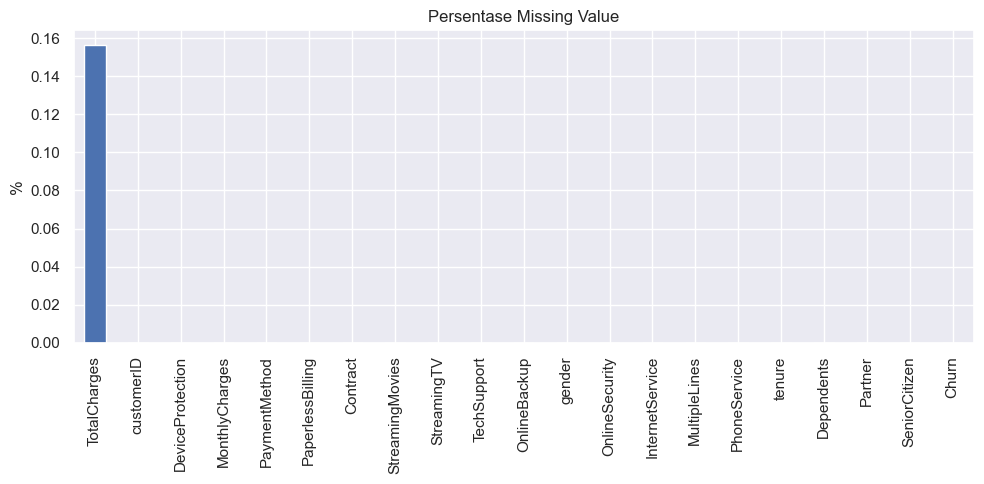

In [4]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

missing_pct = df.isna().mean() * 100
print(missing_pct)

plt.figure(figsize=(10,5))
missing_pct.sort_values(ascending=False).plot(kind='bar')
plt.title("Persentase Missing Value")
plt.ylabel("%")
plt.tight_layout()
plt.show()

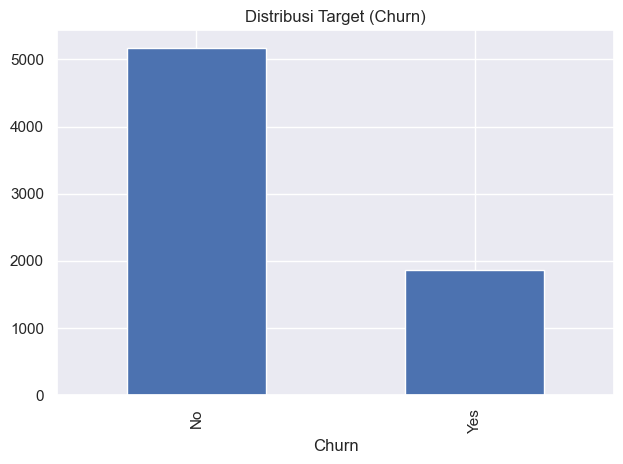

Churn
No     73.463013
Yes    26.536987
Name: proportion, dtype: float64


In [5]:
df['Churn'].value_counts().plot(kind='bar')
plt.title("Distribusi Target (Churn)")
plt.tight_layout()
plt.show()

print(df['Churn'].value_counts(normalize=True) * 100)

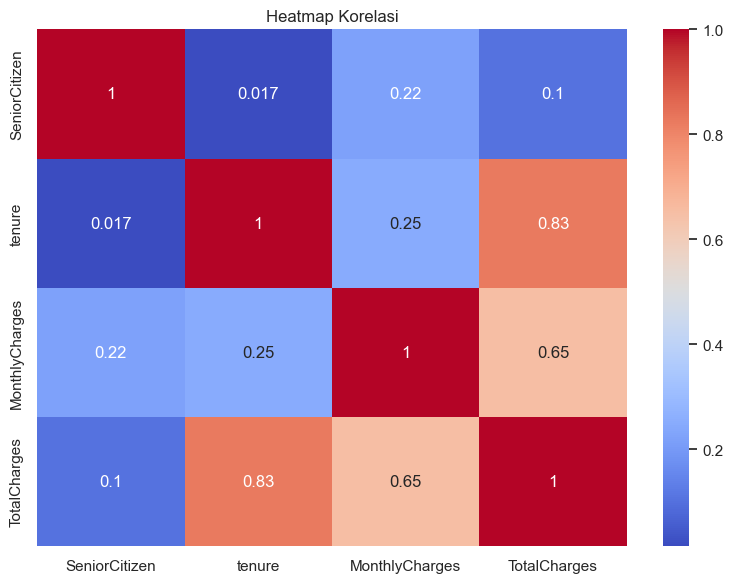

In [6]:
df_num = df.select_dtypes(include=['int64','float64'])

plt.figure(figsize=(8,6))
sns.heatmap(df_num.corr(), annot=True, cmap='coolwarm')
plt.title("Heatmap Korelasi")
plt.tight_layout()
plt.show()

In [7]:
df_prep = df.copy()

df_prep['TotalCharges'] = pd.to_numeric(df_prep['TotalCharges'], errors='coerce')

df_prep['TotalCharges'].fillna(df_prep['TotalCharges'].median(), inplace=True)

for col in ['tenure', 'MonthlyCharges', 'TotalCharges']:
    q1, q99 = df_prep[col].quantile([0.01, 0.99])
    df_prep[col] = df_prep[col].clip(q1, q99)

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_1660\3451273971.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_prep['TotalCharges'].fillna(df_prep['TotalCharges'].median(), inplace=True)


In [8]:
X = df_prep.drop(columns=['Churn', 'customerID'])
y = df_prep['Churn'].map({'No': 0, 'Yes': 1})

cat_cols = X.select_dtypes(include='object').columns
num_cols = X.select_dtypes(include=['int64', 'float64']).columns

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [10]:
preprocess_full = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
    ('num', StandardScaler(), num_cols)
])

In [11]:
def evaluate_model(name, model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"\n=== {name} ===")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(name)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()


=== Direct - Logistic Regression ===
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1035
           1       0.65      0.56      0.60       374

    accuracy                           0.80      1409
   macro avg       0.75      0.73      0.74      1409
weighted avg       0.80      0.80      0.80      1409



C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


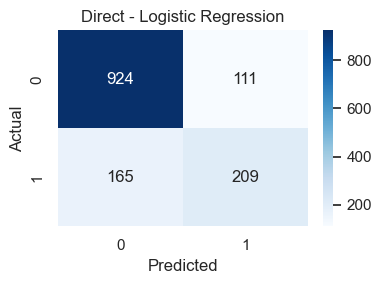


=== Direct - Random Forest ===
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1035
           1       0.61      0.49      0.54       374

    accuracy                           0.78      1409
   macro avg       0.72      0.69      0.70      1409
weighted avg       0.77      0.78      0.77      1409



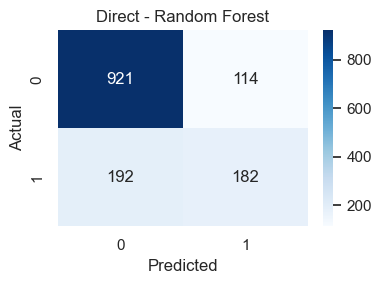

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



=== Direct - Voting ===
              precision    recall  f1-score   support

           0       0.82      0.92      0.87      1035
           1       0.68      0.46      0.55       374

    accuracy                           0.80      1409
   macro avg       0.75      0.69      0.71      1409
weighted avg       0.78      0.80      0.78      1409



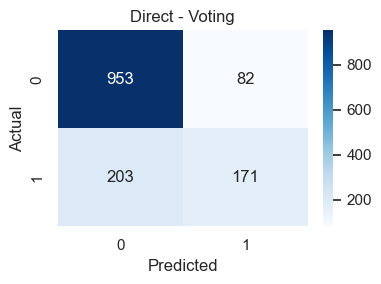

In [12]:
preprocess_direct = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
    ('num', 'passthrough', num_cols)
])

evaluate_model(
    "Direct - Logistic Regression",
    Pipeline([
        ('prep', preprocess_direct),
        ('model', LogisticRegression(max_iter=1000))
    ])
)

evaluate_model(
    "Direct - Random Forest",
    Pipeline([
        ('prep', preprocess_direct),
        ('model', RandomForestClassifier(random_state=42))
    ])
)

evaluate_model(
    "Direct - Voting",
    Pipeline([
        ('prep', preprocess_direct),
        ('model', VotingClassifier(
            estimators=[
                ('lr', LogisticRegression(max_iter=1000)),
                ('knn', KNeighborsClassifier()),
                ('svm', SVC(probability=True))
            ],
            voting='soft'
        ))
    ])
)


=== Preprocess + SMOTE - Logistic Regression ===
              precision    recall  f1-score   support

           0       0.91      0.72      0.80      1035
           1       0.50      0.79      0.62       374

    accuracy                           0.74      1409
   macro avg       0.70      0.76      0.71      1409
weighted avg       0.80      0.74      0.75      1409



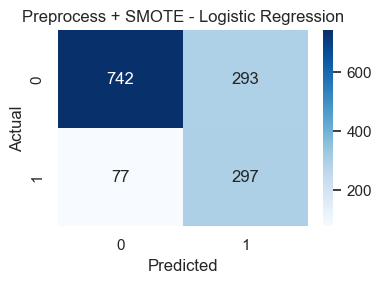


=== Preprocess + SMOTE - Random Forest ===
              precision    recall  f1-score   support

           0       0.84      0.85      0.84      1035
           1       0.56      0.55      0.55       374

    accuracy                           0.77      1409
   macro avg       0.70      0.70      0.70      1409
weighted avg       0.76      0.77      0.77      1409



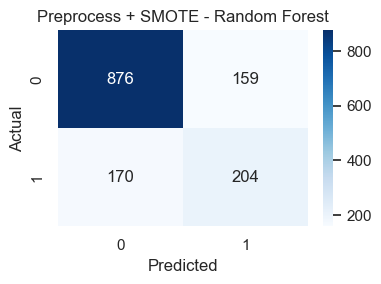


=== Preprocess + SMOTE - Voting ===
              precision    recall  f1-score   support

           0       0.89      0.75      0.81      1035
           1       0.52      0.75      0.61       374

    accuracy                           0.75      1409
   macro avg       0.71      0.75      0.71      1409
weighted avg       0.79      0.75      0.76      1409



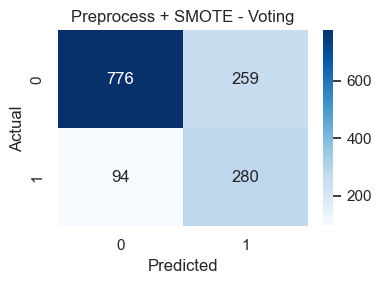

In [13]:
evaluate_model(
    "Preprocess + SMOTE - Logistic Regression",
    ImbPipeline([
        ('prep', preprocess_full),
        ('smote', SMOTE(random_state=42)),
        ('model', LogisticRegression(max_iter=1000))
    ])
)

evaluate_model(
    "Preprocess + SMOTE - Random Forest",
    ImbPipeline([
        ('prep', preprocess_full),
        ('smote', SMOTE(random_state=42)),
        ('model', RandomForestClassifier(random_state=42))
    ])
)

evaluate_model(
    "Preprocess + SMOTE - Voting",
    ImbPipeline([
        ('prep', preprocess_full),
        ('smote', SMOTE(random_state=42)),
        ('model', VotingClassifier(
            estimators=[
                ('lr', LogisticRegression(max_iter=1000)),
                ('knn', KNeighborsClassifier()),
                ('svm', SVC(probability=True))
            ],
            voting='soft'
        ))
    ])
)

In [14]:
from sklearn.model_selection import GridSearchCV
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import joblib

In [15]:
lr_smote = ImbPipeline([
    ('prep', preprocess_full),
    ('smote', SMOTE(random_state=42)),
    ('model', LogisticRegression(max_iter=1000))
])

rf_smote = ImbPipeline([
    ('prep', preprocess_full),
    ('smote', SMOTE(random_state=42)),
    ('model', RandomForestClassifier(random_state=42))
])

voting_smote = ImbPipeline([
    ('prep', preprocess_full),
    ('smote', SMOTE(random_state=42)),
    ('model', VotingClassifier(
        estimators=[
            ('lr', LogisticRegression(max_iter=1000)),
            ('knn', KNeighborsClassifier()),
            ('svm', SVC(probability=True))
        ],
        voting='soft'
    ))
])

In [16]:
param_lr = {
    'model__C': [0.01, 0.1, 1, 10]
}

In [17]:
param_rf = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [None, 10, 20],
    'model__min_samples_split': [2, 5]
}

In [18]:
param_voting = {
    'model__weights': [
        [1,1,1],
        [2,1,1],
        [1,2,1],
        [1,1,2]
    ]
}

In [19]:
grid_lr = GridSearchCV(
    lr_smote,
    param_lr,
    cv=3,
    scoring='f1',
    n_jobs=-1
)
grid_lr.fit(X_train, y_train)
best_lr = grid_lr.best_estimator_

In [20]:
grid_rf = GridSearchCV(
    rf_smote,
    param_rf,
    cv=3,
    scoring='f1',
    n_jobs=-1
)
grid_rf.fit(X_train, y_train)
best_rf = grid_rf.best_estimator_

In [21]:
grid_voting = GridSearchCV(
    voting_smote,
    param_voting,
    cv=3,
    scoring='f1',
    n_jobs=-1
)
grid_voting.fit(X_train, y_train)
best_voting = grid_voting.best_estimator_


=== LogReg + SMOTE + Tuning ===
              precision    recall  f1-score   support

           0       0.90      0.73      0.81      1035
           1       0.51      0.77      0.61       374

    accuracy                           0.74      1409
   macro avg       0.70      0.75      0.71      1409
weighted avg       0.80      0.74      0.76      1409



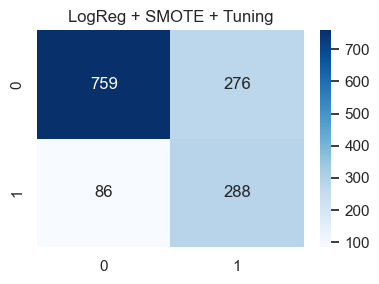


=== RandomForest + SMOTE + Tuning ===
              precision    recall  f1-score   support

           0       0.87      0.80      0.83      1035
           1       0.55      0.68      0.61       374

    accuracy                           0.77      1409
   macro avg       0.71      0.74      0.72      1409
weighted avg       0.79      0.77      0.77      1409



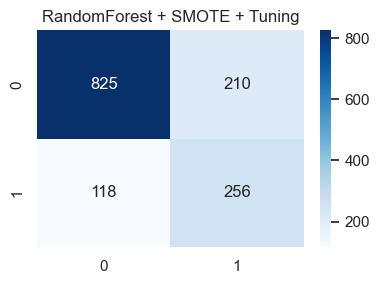


=== Voting + SMOTE + Tuning ===
              precision    recall  f1-score   support

           0       0.90      0.74      0.81      1035
           1       0.52      0.76      0.62       374

    accuracy                           0.75      1409
   macro avg       0.71      0.75      0.72      1409
weighted avg       0.80      0.75      0.76      1409



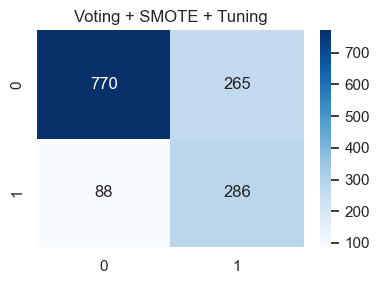

In [22]:
models = {
    "LogReg + SMOTE + Tuning": best_lr,
    "RandomForest + SMOTE + Tuning": best_rf,
    "Voting + SMOTE + Tuning": best_voting
}

results = []

for name, model in models.items():
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)

    f1_churn = report['1']['f1-score']
    results.append([name, f1_churn])

    print(f"\n=== {name} ===")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(name)
    plt.tight_layout()
    plt.show()

In [23]:
results_df = pd.DataFrame(results, columns=['Model', 'F1_Churn'])
results_df = results_df.sort_values(by='F1_Churn', ascending=False)

display(results_df)

,Model,F1_Churn
2,Voting + SMOTE + Tuning,0.618378
0,LogReg + SMOTE + Tuning,0.614072
1,RandomForest + SMOTE + Tuning,0.609524


In [24]:
best_model_name = results_df.iloc[0]['Model']
best_model = models[best_model_name]

joblib.dump(best_model, "best_churn_model_final.pkl")

print("Model terbaik:", best_model_name)
print("Model berhasil disimpan")

Model terbaik: Voting + SMOTE + Tuning
Model berhasil disimpan
